In [1]:
import pickle
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.python.framework import ops
import math

In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
ratings_df = pd.read_csv('ratings_small.csv')

In [4]:
n_ratings, _ = ratings_df.shape
print(ratings_df.head())
print(ratings_df.tail())
print(n_ratings)

   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
        userId  movieId  rating   timestamp
99999      671     6268     2.5  1065579370
100000     671     6269     4.0  1065149201
100001     671     6365     4.0  1070940363
100002     671     6385     2.5  1070979663
100003     671     6565     3.5  1074784724
100004


In [5]:
train_size = int(0.8*n_ratings)
shuffled_indexes = shuffle(range(n_ratings))
df = ratings_df.iloc[shuffled_indexes[:train_size]]
test_df = ratings_df.iloc[shuffled_indexes[train_size:]]

In [6]:
print(df.shape)
print(test_df.shape)

(80003, 4)
(20001, 4)


In [7]:
df_flag = df.pivot(index='movieId', columns='userId', values='rating').isna()==False

In [8]:
df_flag = df_flag.values

In [9]:
col_names = df.pivot(index='movieId', columns='userId', values='rating').columns
row_names = df.pivot(index='movieId', columns='userId', values='rating').index

In [10]:
y_matrix = df.pivot(index='movieId', columns='userId', values='rating').fillna(0).values

In [11]:
n_movies, n_users = y_matrix.shape

In [12]:
print(n_movies, n_users)

8421 671


In [13]:
def create_placeholders(n_y):

    ### START CODE HERE ### (approx. 2 lines)
    Y = tf.compat.v1.placeholder(tf.float32,shape=(n_y, None), name='Y')    
    Y_flag = tf.compat.v1.placeholder(tf.float32, shape=(n_y, None), name="Y_flag")
    ### END CODE HERE ###
    
    return Y, Y_flag

In [14]:
Y, Y_flag = create_placeholders(12288)
print ("Y = " + str(Y))
print ("Y_flag = " + str(Y_flag))

Y = Tensor("Y:0", shape=(12288, None), dtype=float32)
Y_flag = Tensor("Y_flag:0", shape=(12288, None), dtype=float32)


In [15]:
def initialize_parameters(item, user):

    tf.compat.v1.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    X_mat = tf.compat.v1.get_variable("X_mat", [item, 100], initializer = tf.initializers.GlorotUniform(seed = 1))
    theta_mat = tf.compat.v1.get_variable("theta_mat", [100,user], initializer = tf.initializers.GlorotUniform(seed = 1))
    ### END CODE HERE ###

    parameters = {"X_mat": X_mat,
                  "theta_mat": theta_mat}
    
    return parameters

In [16]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as sess:
    parameters = initialize_parameters(500, 600)
    print("X_mat = " + str(parameters["X_mat"]))
    print("theta_mat = " + str(parameters["theta_mat"]))

X_mat = <tf.Variable 'X_mat:0' shape=(500, 100) dtype=float32>
theta_mat = <tf.Variable 'theta_mat:0' shape=(100, 600) dtype=float32>


In [17]:
def compute_cost(X, theta, Y, Y_flag):
       
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_sum(tf.multiply(0.5,tf.multiply(tf.math.squared_difference(tf.matmul(X, theta), Y),Y_flag)))
    ### END CODE HERE ###
    
    return cost

In [18]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as sess:
    Y, Y_flag = create_placeholders(500)
    parameters = initialize_parameters(500, 600)
    cost = compute_cost(parameters["X_mat"],parameters["theta_mat"], Y, Y_flag)
    print("cost = " + str(cost))

cost = Tensor("Sum:0", shape=(), dtype=float32)


In [19]:
def random_mini_batches(Y_mat, Y_flag, mini_batch_size = 64, seed = 0):
    
    m = Y_mat.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = Y_mat[:, permutation]
    shuffled_Y = Y_flag[:, permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [20]:
def model(Y_mat, flag, learning_rate = 0.001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()                         
    tf.compat.v1.set_random_seed(1)                         
    seed = 3                                          
    (n_x, m) = Y_mat.shape                           
    costs = []                                       
    
    Y, Y_flag = create_placeholders(n_x)
    
    parameters = initialize_parameters(n_x, m)
    ### END CODE HERE ###
        
    cost = compute_cost(parameters["X_mat"],parameters["theta_mat"], Y, Y_flag)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.compat.v1.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.compat.v1.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                      
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(Y_mat, flag, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
               
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={Y: minibatch_X, Y_flag: minibatch_Y})
              
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                print(f"epoch_cost: {epoch_cost:{10}}")
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        
        return parameters

Cost after epoch 0: 814.133104
epoch_cost: 814.1331035767511
epoch_cost: 813.9904992548435
epoch_cost: 813.5223546944859
epoch_cost: 812.4956222056632
epoch_cost: 810.8207898658718
epoch_cost: 807.6640275707898
epoch_cost: 802.7795268256334
epoch_cost: 795.6667287630403
epoch_cost: 786.460413561848
epoch_cost: 774.2951751117735
epoch_cost: 759.703381147541
epoch_cost: 742.3363450074515
epoch_cost: 721.9829545454545
epoch_cost: 698.0790331594635
epoch_cost: 671.5171385991058
epoch_cost: 642.0057749627422
epoch_cost: 615.1522447839046
epoch_cost: 581.1797690014903
epoch_cost: 546.6340815946348
epoch_cost: 508.8345752608048
Cost after epoch 100: 472.497113
epoch_cost: 472.4971125186289
epoch_cost: 437.248695976155
epoch_cost: 399.48896236959763
epoch_cost: 367.43831501490314
epoch_cost: 328.1628166915052
epoch_cost: 297.1615359538003
epoch_cost: 266.0827356557377
epoch_cost: 239.57675111773472
epoch_cost: 211.2654154247392
epoch_cost: 185.11319392697467


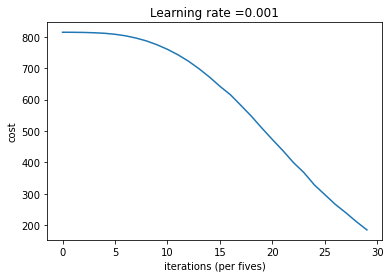

Parameters have been trained!


{'X_mat': array([[-0.17581545, -0.19352752,  0.18397655, ...,  0.21461672,
         -0.18293703, -0.198001  ],
        [-0.20159836, -0.20812227,  0.15605412, ...,  0.17160858,
         -0.20116924, -0.18768239],
        [-0.15358269, -0.18699953,  0.15072171, ...,  0.18588424,
         -0.20108177, -0.18263629],
        ...,
        [-0.12781905, -0.13463815,  0.08914023, ...,  0.13510408,
         -0.08394607, -0.12212799],
        [-0.12636857, -0.12660336,  0.06238794, ...,  0.08220997,
         -0.11626352, -0.09575298],
        [-0.12325702, -0.12066893,  0.10705022, ...,  0.118435  ,
         -0.09218949, -0.11402744]], dtype=float32),
 'theta_mat': array([[-0.05347864, -0.1433918 , -0.11566927, ..., -0.13514626,
         -0.12263036, -0.14213993],
        [-0.15687859, -0.21897617, -0.1201693 , ..., -0.15357524,
         -0.18616422, -0.12946735],
        [ 0.04371995,  0.05822359,  0.09118348, ...,  0.15905453,
          0.10117561,  0.1204949 ],
        ...,
        [ 0.09904

In [21]:
parameters = model(y_matrix, df_flag, minibatch_size = 671, num_epochs = 150)
parameters

In [22]:
results = np.dot(parameters["X_mat"],parameters["theta_mat"])
results.shape

(8421, 671)

In [23]:
rating_filled = pd.DataFrame(np.dot(parameters["X_mat"],parameters["theta_mat"]), columns = col_names, index=row_names)
rating_filled.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,2.366977,2.648089,2.646921,2.465882,2.544121,2.725568,2.139204,2.745687,2.597456,2.490585,...,2.372688,2.877131,3.001487,2.760809,2.701526,2.733214,2.477277,2.354048,2.228546,2.906067
2,2.233545,2.519910,2.510711,2.345076,2.423332,2.586897,2.030870,2.585195,2.458074,2.353964,...,2.268985,2.739997,2.838290,2.598399,2.575665,2.588080,2.335802,2.237893,2.117870,2.771418
3,2.089205,2.366393,2.370973,2.201921,2.269294,2.438067,1.910052,2.445578,2.313964,2.234157,...,2.123559,2.587812,2.668852,2.460845,2.412224,2.427308,2.198983,2.103470,1.985528,2.581726
4,1.735378,1.949167,1.943662,1.803997,1.867004,2.013838,1.552868,2.000992,1.937416,1.830188,...,1.758010,2.130145,2.201481,2.027591,1.995599,2.020041,1.812542,1.732554,1.643269,2.128768
5,2.141469,2.423366,2.416623,2.242188,2.321605,2.483070,1.949414,2.490866,2.339931,2.247541,...,2.174449,2.628363,2.719726,2.510018,2.480333,2.483727,2.262115,2.127614,2.027800,2.639517


In [24]:
rating_filled[212][3269]

1.9361562

In [25]:
df.tail(30)

,userId,movieId,rating,timestamp
68959,478,8368,4.5,1446622638
69464,480,85414,3.5,1339284814
527,7,551,4.0,851868019
91773,607,30793,3.5,1143500416
57964,421,590,5.0,835169969
24040,171,2710,2.0,950556652
44534,312,1687,2.0,959931793
48773,358,81,1.0,957534758
41853,299,42723,4.0,1344189149
45800,328,2137,3.0,1148006401
